https://data.cityofnewyork.us/Environment/New-York-City-s-Flood-Vulnerability-Index/mrjc-v9pm/about_data

This maps two charts, one of which is all of the subway train rides and the second is a NYC Flood Vulnerability index. It aims to see the impact of potential floods on NYC subways. 

However, it only shows the subway stations as vulnerable and not the infrastructure between stops or the actual lines. 

In [51]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt

from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.cm as cm

import matplotlib.colors as mcolors

import geopandas as gpd
import folium
import matplotlib.pyplot as plt

import branca

import pandas as pd
from io import StringIO
import requests

from folium import FeatureGroup


Get Vulnerability Index Data

In [52]:
# Read the shapefile
df = pd.read_csv("New_York_City_s_Flood_Vulnerability_Index_20240930.csv")
# Read the shapefile
gdf = gpd.read_file("/Users/bricenfisher/Downloads/New York City's Flood Vulnerability Index_20240930/geo_export_d5f0fd6a-fb11-4302-8722-c77598d0deab.shp")


Get Transit User Data

In [102]:
def establish_nys_session():
    session = requests.Session()
    # Add headers or authentication if needed
    return session

url = """https://data.ny.gov/resource/wujg-7c2s.csv?$limit=1000000&$query=
SELECT 
    station_complex,
    Georeference,
    fare_class_category,
    round(SUM(transfers),0) AS transfers,
    round(SUM(ridership),0) AS total_ridership
WHERE 
    transit_timestamp >= '2024-09-20T00:00:00' 
    AND 
    transit_timestamp <= '2024-10-07T00:00:00'
GROUP BY 
    station_complex, Georeference,fare_class_category
ORDER BY 
    station_complex
"""


session = establish_nys_session()
response = session.get(url)


# Convert the CSV response to a DataFrame
data = StringIO(response.text)

df = pd.read_csv(data, header=0)

In [103]:
df

{
  "error" : true                                                                NaN
  "message" : "If $query is used   all options - [$limit] should not be specifie...
}                                                                               NaN

In [55]:
df_polygons = gdf
df_points = df

Clean DataFrames

In [56]:
df_points

station_complex                 Georeference  \
0  RI Tramway (Manhattan)  POINT (-73.96416 40.761337)   
1  RI Tramway (Manhattan)  POINT (-73.96416 40.761337)   
2  RI Tramway (Manhattan)  POINT (-73.96416 40.761337)   
3  RI Tramway (Manhattan)  POINT (-73.96416 40.761337)   
4  RI Tramway (Roosevelt)   POINT (-73.95412 40.75734)   
5  RI Tramway (Roosevelt)   POINT (-73.95412 40.75734)   
6  RI Tramway (Roosevelt)   POINT (-73.95412 40.75734)   

            fare_class_category  transfers  total_ridership  
0         Metrocard - Full Fare          1                2  
1             Metrocard - Other          0                1  
2  Metrocard - Unlimited 30-Day          0                3  
3   Metrocard - Unlimited 7-Day          0                3  
4         Metrocard - Fair Fare          0                1  
5             Metrocard - Other          0                1  
6   Metrocard - Unlimited 7-Day          0                1

In [57]:
df_polygons['ss_cur'] = df_polygons['ss_cur'].fillna(0)
df_polygons['ss_50s'] = df_polygons['ss_50s'].fillna(0)
df_polygons['ss_80s'] = df_polygons['ss_80s'].fillna(0)
df_polygons['tid_20s'] = df_polygons['tid_20s'].fillna(0)
df_polygons['tid_50s'] = df_polygons['tid_50s'].fillna(0)
df_polygons['tid_80s'] = df_polygons['tid_80s'].fillna(0)

df_polygons['ss_cur'] = pd.to_numeric(df_polygons['ss_cur'], errors='coerce')
df_polygons['ss_50s'] = pd.to_numeric(df_polygons['ss_50s'], errors='coerce')
df_polygons['ss_80s'] = pd.to_numeric(df_polygons['ss_80s'], errors='coerce')
df_polygons['tid_20s'] = pd.to_numeric(df_polygons['tid_20s'], errors='coerce')
df_polygons['tid_50s'] = pd.to_numeric(df_polygons['tid_50s'], errors='coerce')
df_polygons['tid_80s'] = pd.to_numeric(df_polygons['tid_80s'], errors='coerce')

df_points.columns = df_points.columns.str.strip()
df_polygons.columns = df_polygons.columns.str.strip()

gdf1 = gpd.GeoDataFrame(df_points, geometry=gpd.GeoSeries.from_wkt(df_points['Georeference']))
gdf2 = df_polygons

gdf1 is the subway stations
gdf2 is the polygons of the vulnerable areas

Merge DataFrames

In [58]:
gdf1['Georeference'] = gdf1['Georeference'].apply(wkt.loads)  # Convert the Georeference points from WKT format
gdf1 = gpd.GeoDataFrame(gdf1, geometry='Georeference', crs="EPSG:4326")  # Assuming WGS84 for points
gdf2 = gdf2.set_crs("EPSG:4326", allow_override=True)

In [59]:
gdf1.info()
gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   station_complex      7 non-null      object  
 1   Georeference         7 non-null      geometry
 2   fare_class_category  7 non-null      object  
 3   transfers            7 non-null      int64   
 4   total_ridership      7 non-null      int64   
 5   geometry             7 non-null      geometry
dtypes: geometry(2), int64(2), object(2)
memory usage: 464.0+ bytes
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2209 entries, 0 to 2208
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     2209 non-null   object  
 1   fshri     2207 non-null   object  
 2   ss_cur    2209 non-null   int64   
 3   ss_50s    2209 non-null   int64   
 4   ss_80s    2209 non-null   int64   
 5   tid_20s   2209 no

In [60]:
def get_pip (gdf, regions):
    r_list = list(regions.geoid)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.geoid==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region geoid as the value
        pip_data['region']= r
        #append region data to empty dataframe
        df = pd.concat([df,pip_data])
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

eq_df = get_pip(gdf1, gdf2)

Original dataframe count= 7 
New dataframe count= 7


/var/folders/wm/w3d80c152lq65mt41y20p1200000gn/T/ipykernel_60292/681669060.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pip_data])


In [61]:
eq_df

station_complex                Georeference  \
0  RI Tramway (Roosevelt)  POINT (-73.95412 40.75734)   
1  RI Tramway (Roosevelt)  POINT (-73.95412 40.75734)   
2  RI Tramway (Roosevelt)  POINT (-73.95412 40.75734)   
3  RI Tramway (Manhattan)  POINT (-73.96416 40.76134)   
4  RI Tramway (Manhattan)  POINT (-73.96416 40.76134)   
5  RI Tramway (Manhattan)  POINT (-73.96416 40.76134)   
6  RI Tramway (Manhattan)  POINT (-73.96416 40.76134)   

            fare_class_category  transfers  total_ridership       region  
0         Metrocard - Fair Fare        0.0              1.0  36061023804  
1             Metrocard - Other        0.0              1.0  36061023804  
2   Metrocard - Unlimited 7-Day        0.0              1.0  36061023804  
3         Metrocard - Full Fare        1.0              2.0  36061011000  
4             Metrocard - Other        0.0              1.0  36061011000  
5  Metrocard - Unlimited 30-Day        0.0              3.0  36061011000  
6   Metrocard - Unlimited 7-Day        0.0              3.0  36061011000

In [62]:
summed_ridership = eq_df.groupby('region')['total_ridership'].sum()
summed_ridership = summed_ridership.reset_index()
summed_ridership.columns = ['geoid', 'total_ridership']
summed_ridership

geoid  total_ridership
0  36061011000              9.0
1  36061023804              3.0

In [63]:
gdf2

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2204  36061004700     1       3       3       3        0        0        0   
2205  36061025500     1       0       0       0        0        0        0   
2206  36061027700     1       0       0       0        0        0        0   
2207  36005009302   NaN       0       0       0        0        0        0   
2208  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...  
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...  
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...  
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...  
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...  
...                                                 ...  
2204  POLYGON ((-74.00479 40.72362, -74.00458 40.724...  
2205  POLYGON ((-73.95416 40.84799, -73.95283 40.851...  
2206  POLYGON ((-73.93008 40.85431, -73.92964 40.854...  
2207  POLYGON ((-73.90307 40.80988, -73.89917 40.812...  
2208  POLYGON ((-73.84494 40.84821, -73.84359 40.850...  

[2209 rows x 9 columns]

In [64]:
print(gdf2['geoid'].nunique())


2209


In [65]:
summed_ridership

geoid  total_ridership
0  36061011000              9.0
1  36061023804              3.0

In [66]:
gdf_with_ridership = gdf2.merge(summed_ridership, on = "geoid", how = 'left')

In [67]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2204  36061004700     1       3       3       3        0        0        0   
2205  36061025500     1       0       0       0        0        0        0   
2206  36061027700     1       0       0       0        0        0        0   
2207  36005009302   NaN       0       0       0        0        0        0   
2208  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              NaN  
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...              NaN  
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...              NaN  
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              NaN  
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              NaN  
...                                                 ...              ...  
2204  POLYGON ((-74.00479 40.72362, -74.00458 40.724...              NaN  
2205  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              NaN  
2206  POLYGON ((-73.93008 40.85431, -73.92964 40.854...              NaN  
2207  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              NaN  
2208  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              NaN  

[2209 rows x 10 columns]

In [68]:
eq_df
eq_df_merge = eq_df[['station_complex','region']]

In [69]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2204  36061004700     1       3       3       3        0        0        0   
2205  36061025500     1       0       0       0        0        0        0   
2206  36061027700     1       0       0       0        0        0        0   
2207  36005009302   NaN       0       0       0        0        0        0   
2208  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              NaN  
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...              NaN  
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...              NaN  
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              NaN  
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              NaN  
...                                                 ...              ...  
2204  POLYGON ((-74.00479 40.72362, -74.00458 40.724...              NaN  
2205  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              NaN  
2206  POLYGON ((-73.93008 40.85431, -73.92964 40.854...              NaN  
2207  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              NaN  
2208  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              NaN  

[2209 rows x 10 columns]

In [70]:
gdf_with_ridership = pd.merge(gdf_with_ridership, eq_df_merge, left_on='geoid', right_on='region', how='left')

In [71]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2209  36061004700     1       3       3       3        0        0        0   
2210  36061025500     1       0       0       0        0        0        0   
2211  36061027700     1       0       0       0        0        0        0   
2212  36005009302   NaN       0       0       0        0        0        0   
2213  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              NaN   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...              NaN   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...              NaN   
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              NaN   
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              NaN   
...                                                 ...              ...   
2209  POLYGON ((-74.00479 40.72362, -74.00458 40.724...              NaN   
2210  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              NaN   
2211  POLYGON ((-73.93008 40.85431, -73.92964 40.854...              NaN   
2212  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              NaN   
2213  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              NaN   

     station_complex region  
0                NaN    NaN  
1                NaN    NaN  
2                NaN    NaN  
3                NaN    NaN  
4                NaN    NaN  
...              ...    ...  
2209             NaN    NaN  
2210             NaN    NaN  
2211             NaN    NaN  
2212             NaN    NaN  
2213             NaN    NaN  

[2214 rows x 12 columns]

In [72]:
gdf_with_ridership
gdf_with_ridership['total_ridership'] = gdf_with_ridership['total_ridership'].fillna(0)
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2209  36061004700     1       3       3       3        0        0        0   
2210  36061025500     1       0       0       0        0        0        0   
2211  36061027700     1       0       0       0        0        0        0   
2212  36005009302   NaN       0       0       0        0        0        0   
2213  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              0.0   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...              0.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...              0.0   
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              0.0   
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              0.0   
...                                                 ...              ...   
2209  POLYGON ((-74.00479 40.72362, -74.00458 40.724...              0.0   
2210  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              0.0   
2211  POLYGON ((-73.93008 40.85431, -73.92964 40.854...              0.0   
2212  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              0.0   
2213  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              0.0   

     station_complex region  
0                NaN    NaN  
1                NaN    NaN  
2                NaN    NaN  
3                NaN    NaN  
4                NaN    NaN  
...              ...    ...  
2209             NaN    NaN  
2210             NaN    NaN  
2211             NaN    NaN  
2212             NaN    NaN  
2213             NaN    NaN  

[2214 rows x 12 columns]

Some Prelim Data Analysis and Plots

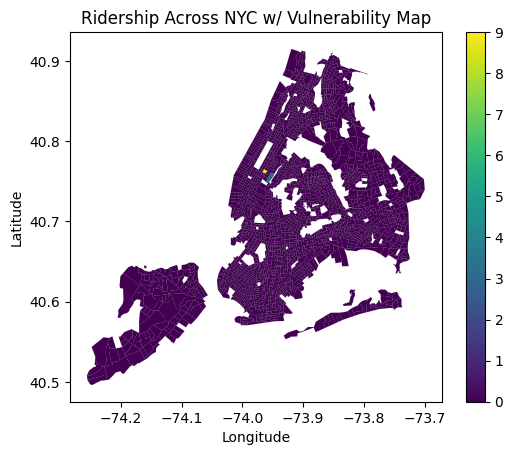

In [73]:
gdf_with_ridership.plot(column='total_ridership', legend=True, edgecolor='black',linewidth= 0.05)

plt.title('Ridership Across NYC w/ Vulnerability Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

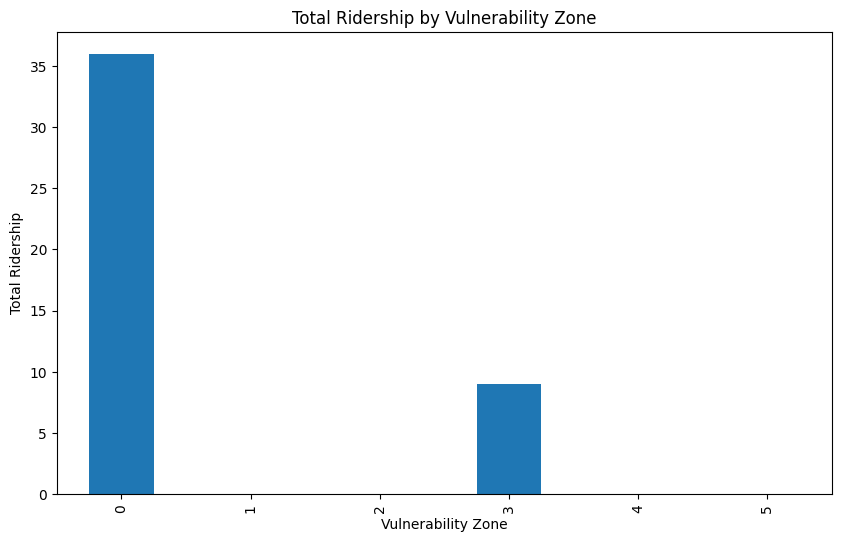

In [74]:
gdf_with_ridership.groupby("ss_cur")["total_ridership"].sum().plot(kind='bar', figsize=(10,6))
# Add labels and title
plt.xlabel("Vulnerability Zone")
plt.ylabel("Total Ridership")
plt.title("Total Ridership by Vulnerability Zone")

# Show the plot
plt.show()

There are 14 stations in zone 5 vulnerability

In [75]:
print(gdf_with_ridership.groupby("ss_cur")["total_ridership"].count())


ss_cur
0    1851
1      72
2      72
3      74
4      72
5      73
Name: total_ridership, dtype: int64


In [76]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2209  36061004700     1       3       3       3        0        0        0   
2210  36061025500     1       0       0       0        0        0        0   
2211  36061027700     1       0       0       0        0        0        0   
2212  36005009302   NaN       0       0       0        0        0        0   
2213  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              0.0   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...              0.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...              0.0   
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              0.0   
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              0.0   
...                                                 ...              ...   
2209  POLYGON ((-74.00479 40.72362, -74.00458 40.724...              0.0   
2210  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              0.0   
2211  POLYGON ((-73.93008 40.85431, -73.92964 40.854...              0.0   
2212  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              0.0   
2213  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              0.0   

     station_complex region  
0                NaN    NaN  
1                NaN    NaN  
2                NaN    NaN  
3                NaN    NaN  
4                NaN    NaN  
...              ...    ...  
2209             NaN    NaN  
2210             NaN    NaN  
2211             NaN    NaN  
2212             NaN    NaN  
2213             NaN    NaN  

[2214 rows x 12 columns]

In [77]:
Zone_0_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 0]
Zone_1_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 1]
Zone_2_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 2]
Zone_3_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 3]
Zone_4_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 4]
Zone_5_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 5]

geo_json_data_Zone_0_ss_cur = Zone_0_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_1_ss_cur = Zone_1_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_2_ss_cur = Zone_2_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_3_ss_cur = Zone_3_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_4_ss_cur = Zone_4_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_5_ss_cur = Zone_5_ss_cur.to_crs(epsg=4326).to_json()

m = folium.Map(location=[40.643315421898, -73.95109946110213], zoom_start=10.5, tiles = 'Cartodb Positron')

# Create three different FeatureGroups for different layers
group0 = FeatureGroup(name='Zone 0', show=True)  # Show this group by default
group1 = FeatureGroup(name='Zone 1', show=True)  # Initially hidden
group2 = FeatureGroup(name='Zone 2', show=True)  # Initially hidden
group3 = FeatureGroup(name='Zone 3', show=True)  # Initially hidden
group4 = FeatureGroup(name='Zone 4', show=True)  # Initially hidden
group5 = FeatureGroup(name='Zone 5', show=True)  # Initially hidden

# Add some markers to each layer
group0.add_child(folium.GeoJson(geo_json_data_Zone_0_ss_cur, name="Polygons"))
group1.add_child(folium.GeoJson(geo_json_data_Zone_1_ss_cur, name="Polygons"))
group2.add_child(folium.GeoJson(geo_json_data_Zone_2_ss_cur, name="Polygons"))
group3.add_child(folium.GeoJson(geo_json_data_Zone_3_ss_cur, name="Polygons"))
group4.add_child(folium.GeoJson(geo_json_data_Zone_4_ss_cur, name="Polygons"))
group5.add_child(folium.GeoJson(geo_json_data_Zone_5_ss_cur, name="Polygons"))


# Add FeatureGroups to the map
m.add_child(group0)
m.add_child(group1)
m.add_child(group2)
m.add_child(group3)
m.add_child(group4)
m.add_child(group5)

# Add Layer Control to toggle between layers
folium.LayerControl(collapsed=False).add_to(m)  # Expanded by default

m

In [78]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2209  36061004700     1       3       3       3        0        0        0   
2210  36061025500     1       0       0       0        0        0        0   
2211  36061027700     1       0       0       0        0        0        0   
2212  36005009302   NaN       0       0       0        0        0        0   
2213  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              0.0   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...              0.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...              0.0   
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              0.0   
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              0.0   
...                                                 ...              ...   
2209  POLYGON ((-74.00479 40.72362, -74.00458 40.724...              0.0   
2210  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              0.0   
2211  POLYGON ((-73.93008 40.85431, -73.92964 40.854...              0.0   
2212  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              0.0   
2213  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              0.0   

     station_complex region  
0                NaN    NaN  
1                NaN    NaN  
2                NaN    NaN  
3                NaN    NaN  
4                NaN    NaN  
...              ...    ...  
2209             NaN    NaN  
2210             NaN    NaN  
2211             NaN    NaN  
2212             NaN    NaN  
2213             NaN    NaN  

[2214 rows x 12 columns]

In [79]:
Zone_0_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 0]
Zone_1_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 1]
Zone_2_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 2]
Zone_3_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 3]
Zone_4_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 4]
Zone_5_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 5]

geo_json_data_Zone_0_ss_cur = Zone_0_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_1_ss_cur = Zone_1_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_2_ss_cur = Zone_2_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_3_ss_cur = Zone_3_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_4_ss_cur = Zone_4_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_5_ss_cur = Zone_5_ss_cur.to_crs(epsg=4326).to_json()

# Define a colormap based on the 'total_ridership' values
min_value = gdf_with_ridership['total_ridership'].min()
max_value = gdf_with_ridership['total_ridership'].max()

# Create a color map (e.g., Viridis colormap)
colors = ['#f7fcf0', '#e0f3db', '#ccece6', '#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#006d2c']
colormap = branca.colormap.StepColormap(colors, vmin=min_value, vmax=max_value, index=[min_value + (max_value - min_value) * i / (len(colors) - 1) for i in range(len(colors))])
colormap.caption = 'Total Ridership'  # Add a caption for the color legend
"""
# Function to style the GeoJson based on the 'total_ridership' value
def style_function(feature):
    ridership_value = feature['properties']['total_ridership']
    return {
        'fillColor': colormap(ridership_value),
        'color': 'black',  # Polygon border color
        'weight': 1,  # Border thickness
        'fillOpacity': 0.7,  # Transparency of the fill color
    }

"""
# Function to style the GeoJson based on the 'total_ridership' value
def style_function(feature):
    ridership_value = feature['properties']['total_ridership']
    if ridership_value == 0:
        return {
            'fillColor': 'transparent',  # Make the fill color transparent
            'color': 'black',  # Make the border color transparent
            'weight': 0.5,  # No border
            'fillOpacity': 0,  # Fully transparent
        }
    else:
        return {
            'fillColor': colormap(ridership_value),
            'color': 'black',  # Polygon border color
            'weight': 0.5,  # Border thickness
            'fillOpacity': 0.7,  # Transparency of the fill color
        }

m = folium.Map(location=[40.643315421898, -73.95109946110213], zoom_start=10.5, tiles = 'Cartodb Positron')

# Create three different FeatureGroups for different layers
group0 = FeatureGroup(name='Zone 0', show=True)  # Show this group by default
group1 = FeatureGroup(name='Zone 1', show=True)  # Initially hidden
group2 = FeatureGroup(name='Zone 2', show=True)  # Initially hidden
group3 = FeatureGroup(name='Zone 3', show=True)  # Initially hidden
group4 = FeatureGroup(name='Zone 4', show=True)  # Initially hidden
group5 = FeatureGroup(name='Zone 5', show=True)  # Initially hidden

# Add some markers to each layer

group0.add_child(
    folium.GeoJson(
    geo_json_data_Zone_0_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group1.add_child(
    folium.GeoJson(
    geo_json_data_Zone_1_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group2.add_child(
    folium.GeoJson(
    geo_json_data_Zone_2_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group3.add_child(
    folium.GeoJson(
    geo_json_data_Zone_3_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group4.add_child(
    folium.GeoJson(
    geo_json_data_Zone_4_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group5.add_child(
    folium.GeoJson(
    geo_json_data_Zone_5_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)


# Add FeatureGroups to the map
m.add_child(group0)
m.add_child(group1)
m.add_child(group2)
m.add_child(group3)
m.add_child(group4)
m.add_child(group5)

# Add Layer Control to toggle between layers
folium.LayerControl('topleft',show=False).add_to(m)  # Expanded by default
colormap.add_to(m)

m